# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups               
Sample_113  P10619;P10619-2;X6R5C5;X6R8A1   20.753
Sample_016  Q9BQT9;Q9BQT9-2                 19.188
Sample_036  P41222                          28.373
Sample_168  P00747                          20.922
Sample_209  P27169                          19.293
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups   
Sample_020  Q9BYJ0              10.378
Sample_194  P54289-2;P54289-3   16.498
Sample_158  P05997              13.763
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.716
            A0A075B6Q5                 13.058
            A0A075B6R2                 12.388
            A0A075B6S5                 13.946
            A0A087WSY4                 11.620
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.925
            Q9UI40;Q9UI40-2            14.247
            Q9UIW2                     12.600
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.959
            Q9UP79                     12.050
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,11.732,15.050,16.842,19.863,14.134,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.132,19.067,...,15.528,15.576,12.892,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,14.133,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.568,17.705,17.039,13.703,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.835,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,11.880,15.345,17.084,18.708,14.249,19.433,10.779,9.988
Sample_207,15.739,16.877,15.469,16.898,12.762,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.716,...,16.012,15.178,11.927,15.050,16.842,19.863,11.248,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.412,19.067,16.188,...,15.528,15.576,11.692,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.693,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,11.684,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.343,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.936,15.345,17.084,18.708,14.249,19.433,12.429,13.711
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 394.46it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.98it/s]

100%|██████████| 2/2 [00:00<00:00,  3.96it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.20it/s]

100%|██████████| 3/3 [00:00<00:00,  3.48it/s]

100%|██████████| 3/3 [00:00<00:00,  3.72it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.97it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

100%|██████████| 4/4 [00:01<00:00,  2.98it/s]

100%|██████████| 4/4 [00:01<00:00,  3.44it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.09it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.60it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.11it/s]

100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

100%|██████████| 5/5 [00:02<00:00,  2.21it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.12it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.20it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.23it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.18it/s]

100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.28it/s]

 43%|████▎     | 3/7 [00:00<00:01,  2.98it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.69it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.65it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.78it/s]

100%|██████████| 7/7 [00:02<00:00,  2.71it/s]

100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.25it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.31it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.59it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.27it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.09it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.16it/s]

100%|██████████| 8/8 [00:03<00:00,  2.24it/s]

100%|██████████| 8/8 [00:03<00:00,  2.39it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.92it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.50it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.16it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.23it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.34it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.47it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.63it/s]

100%|██████████| 9/9 [00:03<00:00,  2.75it/s]

100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.17it/s]

 30%|███       | 3/10 [00:00<00:02,  3.02it/s]

 40%|████      | 4/10 [00:01<00:01,  3.02it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.54it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.72it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.83it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.85it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.89it/s]

100%|██████████| 10/10 [00:03<00:00,  2.85it/s]

100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.72it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.75it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.63it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.34it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.01it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.96it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.79it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.74it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.71it/s]

100%|██████████| 11/11 [00:03<00:00,  2.87it/s]

100%|██████████| 11/11 [00:03<00:00,  3.04it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.44it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.30it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.85it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.27it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.11it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.93it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.65it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.60it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.53it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.60it/s]

100%|██████████| 12/12 [00:04<00:00,  2.78it/s]

100%|██████████| 12/12 [00:04<00:00,  2.97it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.24it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.65it/s]

 31%|███       | 4/13 [00:01<00:02,  3.37it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.16it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.04it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.85it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.67it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.80it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.93it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.03it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.09it/s]

100%|██████████| 13/13 [00:04<00:00,  3.04it/s]

100%|██████████| 13/13 [00:04<00:00,  3.08it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.01it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.09it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.48it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.24it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.09it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.82it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.90it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.05it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.06it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.14it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.15it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.20it/s]

100%|██████████| 14/14 [00:04<00:00,  3.21it/s]

100%|██████████| 14/14 [00:04<00:00,  3.23it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.83it/s]

 20%|██        | 3/15 [00:00<00:03,  3.62it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.09it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.89it/s]

 40%|████      | 6/15 [00:01<00:03,  2.93it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.90it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.77it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.81it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.81it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.84it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.96it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.09it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.17it/s]

100%|██████████| 15/15 [00:04<00:00,  3.25it/s]

100%|██████████| 15/15 [00:04<00:00,  3.07it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.055 0.017          0.799 0.303       0.122   
2             0.006 0.005      0.082 0.020          0.709 0.089       0.603   
3             0.006 0.006      0.070 0.029          0.684 0.089       0.618   
4             0.006 0.006      0.077 0.032          0.721 0.082       0.676   
5             0.004 0.000      0.049 0.008          0.701 0.082       0.658   
6             0.005 0.003      0.059 0.023          0.723 0.081       0.699   
7             0.005 0.003      0.058 0.018          0.786 0.082       0.806   
8             0.004 0.002      0.055 0.019          0.793 0.086       0.807   
9             0.004 0.002      0.052 0.015          0.821 0.080       0.819   
10            0.004 0.002      0.048 0.008          0.823 0.079       0.828   
11            0.004 0.002      0.049 0.013          0.830 0.077       0.849   
12            0.005 0.003      0.061 0.028          0.842 0.073       0.835   
13            0.006 0.004      0.068 0.028          0.841 0.075       0.832   
14            0.006 0.005      0.061 0.019          0.838 0.076       0.833   
15            0.005 0.002      0.062 0.024          0.841 0.086       0.822   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.083   0.204 0.125                  0.553 0.041        0.858   
2          0.102   0.646 0.079                  0.709 0.058        0.787   
3          0.108   0.644 0.082                  0.703 0.062        0.780   
4          0.106   0.692 0.078                  0.741 0.061        0.800   
5          0.110   0.672 0.074                  0.724 0.053        0.799   
6          0.104   0.705 0.070                  0.749 0.055        0.817   
7          0.111   0.791 0.077                  0.821 0.066        0.906   
8          0.108   0.795 0.076                  0.825 0.065        0.904   
9          0.109   0.817 0.079                  0.844 0.067        0.917   
10         0.107   0.822 0.079                  0.849 0.068        0.917   
11         0.100   0.836 0.073                  0.860 0.063        0.921   
12         0.099   0.836 0.072                  0.860 0.062        0.924   
13         0.099   0.834 0.073                  0.858 0.062        0.923   
14         0.097   0.833 0.073                  0.857 0.063        0.922   
15         0.097   0.827 0.069                  0.852 0.058        0.926   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.830 0.091        210.000 0.000  
2          0.068                  0.763 0.086        210.000 0.000  
3          0.067                  0.754 0.084        210.000 0.000  
4          0.066                  0.768 0.084        210.000 0.000  
5          0.060                  0.761 0.079        210.000 0.000  
6          0.058                  0.791 0.075        210.000 0.000  
7          0.049                  0.884 0.057        210.000 0.000  
8          0.049                  0.880 0.057        210.000 0.000  
9          0.048                  0.904 0.052        210.000 0.000  
10         0.048                  0.904 0.053        210.000 0.000  
11         0.047                  0.914 0.046        210.000 0.000  
12         0.046                  0.916 0.047        210.000 0.000  
13         0.047                  0.915 0.048        210.000 0.000  
14         0.047                  0.914 0.048        210.000 0.000  
15         0.043                  0.918 0.042 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 446.92it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.73it/s]

100%|██████████| 2/2 [00:00<00:00,  5.69it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.70it/s]

100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.16it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.11it/s]

100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.08it/s]

 60%|██████    | 3/5 [00:00<00:00,  2.89it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.58it/s]

100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

100%|██████████| 5/5 [00:01<00:00,  2.69it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.69it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.02it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.65it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.50it/s]

100%|██████████| 6/6 [00:02<00:00,  2.59it/s]

100%|██████████| 6/6 [00:02<00:00,  2.71it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.77it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.23it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.81it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.65it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.73it/s]

100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

100%|██████████| 7/7 [00:02<00:00,  2.92it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.86it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.30it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.00it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.84it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.81it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.77it/s]

100%|██████████| 8/8 [00:02<00:00,  2.83it/s]

100%|██████████| 8/8 [00:02<00:00,  2.97it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.26it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.42it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.10it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.89it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.87it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.95it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.99it/s]

100%|██████████| 9/9 [00:02<00:00,  2.85it/s]

100%|██████████| 9/9 [00:02<00:00,  3.01it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.33it/s]

 30%|███       | 3/10 [00:00<00:02,  3.42it/s]

 40%|████      | 4/10 [00:01<00:01,  3.04it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.79it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.81it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.77it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.76it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.82it/s]

100%|██████████| 10/10 [00:03<00:00,  2.75it/s]

100%|██████████| 10/10 [00:03<00:00,  2.92it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.05it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.31it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.78it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.49it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.60it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.65it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.79it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.71it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.65it/s]

100%|██████████| 11/11 [00:03<00:00,  2.72it/s]

100%|██████████| 11/11 [00:03<00:00,  2.79it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.94it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.33it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.86it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.69it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.62it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.75it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.80it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.70it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.75it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.70it/s]

100%|██████████| 12/12 [00:04<00:00,  2.62it/s]

100%|██████████| 12/12 [00:04<00:00,  2.79it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.99it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.31it/s]

 31%|███       | 4/13 [00:01<00:03,  2.72it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.70it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.82it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.90it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.95it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.95it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.99it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.95it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.99it/s]

100%|██████████| 13/13 [00:04<00:00,  2.89it/s]

100%|██████████| 13/13 [00:04<00:00,  2.97it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.58it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.77it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.16it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.80it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.72it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.71it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.82it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.83it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.76it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.76it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.82it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.85it/s]

100%|██████████| 14/14 [00:04<00:00,  2.45it/s]

100%|██████████| 14/14 [00:04<00:00,  2.81it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.32it/s]

 20%|██        | 3/15 [00:00<00:03,  3.79it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.12it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.07it/s]

 40%|████      | 6/15 [00:01<00:02,  3.01it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.94it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.93it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.93it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.88it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.83it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.85it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.78it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.32it/s]

100%|██████████| 15/15 [00:05<00:00,  2.04it/s]

100%|██████████| 15/15 [00:05<00:00,  2.70it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.052 0.012          0.822 0.295       0.134   
2             0.004 0.003      0.072 0.023          0.609 0.113       0.478   
3             0.006 0.005      0.072 0.031          0.817 0.083       0.725   
4             0.006 0.005      0.068 0.027          0.807 0.082       0.764   
5             0.004 0.000      0.046 0.007          0.816 0.083       0.767   
6             0.003 0.001      0.038 0.018          0.806 0.087       0.757   
7             0.004 0.002      0.050 0.017          0.836 0.089       0.782   
8             0.004 0.002      0.060 0.027          0.836 0.091       0.785   
9             0.006 0.004      0.061 0.021          0.824 0.079       0.844   
10            0.005 0.003      0.058 0.022          0.829 0.077       0.841   
11            0.006 0.004      0.062 0.026          0.836 0.079       0.842   
12            0.006 0.004      0.062 0.023          0.834 0.073       0.838   
13            0.005 0.004      0.067 0.024          0.856 0.081       0.840   
14            0.006 0.005      0.064 0.020          0.853 0.079       0.837   
15            0.005 0.004      0.055 0.018          0.841 0.076       0.819   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.221 0.130                  0.559 0.043        0.853   
2          0.121   0.526 0.098                  0.624 0.064        0.705   
3          0.102   0.763 0.072                  0.802 0.058        0.908   
4          0.110   0.779 0.073                  0.813 0.059        0.908   
5          0.109   0.785 0.071                  0.818 0.058        0.906   
6          0.104   0.776 0.075                  0.810 0.061        0.902   
7          0.108   0.802 0.074                  0.833 0.062        0.913   
8          0.106   0.804 0.072                  0.834 0.061        0.912   
9          0.096   0.830 0.067                  0.855 0.059        0.919   
10         0.096   0.832 0.067                  0.856 0.056        0.922   
11         0.089   0.836 0.066                  0.859 0.056        0.921   
12         0.086   0.832 0.055                  0.856 0.047        0.923   
13         0.087   0.844 0.065                  0.867 0.055        0.925   
14         0.085   0.842 0.063                  0.864 0.054        0.924   
15         0.089   0.826 0.058                  0.851 0.049        0.923   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.825 0.088        210.000 0.000  
2          0.082                  0.655 0.098        210.000 0.000  
3          0.047                  0.884 0.059        210.000 0.000  
4          0.046                  0.886 0.055        210.000 0.000  
5          0.048                  0.885 0.056        210.000 0.000  
6          0.050                  0.881 0.058        210.000 0.000  
7          0.052                  0.896 0.060        210.000 0.000  
8          0.052                  0.896 0.061        210.000 0.000  
9          0.047                  0.906 0.051        210.000 0.000  
10         0.047                  0.908 0.054        210.000 0.000  
11         0.047                  0.906 0.053        210.000 0.000  
12         0.046                  0.909 0.052        210.000 0.000  
13         0.046                  0.913 0.050        210.000 0.000  
14         0.046                  0.912 0.051        210.000 0.000  
15         0.046                  0.910 0.051 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 891.27it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 24.74it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.97it/s]

100%|██████████| 3/3 [00:00<00:00, 17.88it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 18.30it/s]

100%|██████████| 4/4 [00:00<00:00, 16.87it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 20.42it/s]

100%|██████████| 5/5 [00:00<00:00, 16.79it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 19.61it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 17.10it/s]

100%|██████████| 6/6 [00:00<00:00, 16.79it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 17.52it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 15.31it/s]

100%|██████████| 7/7 [00:00<00:00, 14.70it/s]

100%|██████████| 7/7 [00:00<00:00, 15.03it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 15.18it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 11.73it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 11.59it/s]

100%|██████████| 8/8 [00:00<00:00, 12.36it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 13.78it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 11.00it/s]

 78%|███████▊  | 7/9 [00:00<00:00,  9.15it/s]

 89%|████████▉ | 8/9 [00:00<00:00,  8.90it/s]

100%|██████████| 9/9 [00:00<00:00,  8.64it/s]

100%|██████████| 9/9 [00:00<00:00,  9.24it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 14.62it/s]

 50%|█████     | 5/10 [00:00<00:00, 10.68it/s]

 70%|███████   | 7/10 [00:00<00:00,  8.90it/s]

 80%|████████  | 8/10 [00:00<00:00,  8.23it/s]

 90%|█████████ | 9/10 [00:00<00:00,  8.45it/s]

100%|██████████| 10/10 [00:01<00:00,  9.44it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 27.22it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 21.50it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 20.25it/s]

100%|██████████| 11/11 [00:00<00:00, 20.65it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 23.31it/s]

 50%|█████     | 6/12 [00:00<00:00, 16.15it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 15.92it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 13.47it/s]

100%|██████████| 12/12 [00:00<00:00, 13.17it/s]

100%|██████████| 12/12 [00:00<00:00, 14.35it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 25.55it/s]

 46%|████▌     | 6/13 [00:00<00:00, 14.77it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 12.98it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 11.47it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 10.74it/s]

100%|██████████| 13/13 [00:01<00:00, 11.83it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 23.60it/s]

 43%|████▎     | 6/14 [00:00<00:00, 17.85it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 14.13it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 13.82it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 14.51it/s]

100%|██████████| 14/14 [00:00<00:00, 14.60it/s]

100%|██████████| 14/14 [00:00<00:00, 15.07it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 16.62it/s]

 33%|███▎      | 5/15 [00:00<00:00, 15.50it/s]

 47%|████▋     | 7/15 [00:00<00:00, 15.95it/s]

 60%|██████    | 9/15 [00:00<00:00, 13.97it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 14.53it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 12.99it/s]

100%|██████████| 15/15 [00:01<00:00, 13.76it/s]

100%|██████████| 15/15 [00:01<00:00, 14.22it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.001      0.050 0.019          0.413 0.473       0.031   
2             0.004 0.000      0.047 0.005          0.629 0.144       0.277   
3             0.003 0.001      0.043 0.009          0.637 0.141       0.288   
4             0.004 0.002      0.045 0.011          0.605 0.138       0.319   
5             0.008 0.005      0.074 0.026          0.586 0.137       0.348   
6             0.006 0.005      0.063 0.023          0.577 0.137       0.343   
7             0.005 0.004      0.050 0.015          0.567 0.136       0.384   
8             0.004 0.000      0.047 0.004          0.556 0.105       0.383   
9             0.004 0.001      0.055 0.021          0.525 0.114       0.366   
10            0.003 0.001      0.034 0.012          0.508 0.115       0.363   
11            0.005 0.003      0.055 0.022          0.494 0.108       0.357   
12            0.003 0.001      0.030 0.006          0.490 0.108       0.359   
13            0.005 0.003      0.053 0.020          0.500 0.112       0.388   
14            0.005 0.003      0.055 0.023          0.513 0.099       0.420   
15            0.005 0.002      0.054 0.015          0.580 0.105       0.474   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.037   0.057 0.067                  0.510 0.021        0.717   
2          0.082   0.376 0.088                  0.573 0.050        0.635   
3          0.108   0.386 0.110                  0.581 0.060        0.615   
4          0.104   0.408 0.099                  0.579 0.057        0.631   
5          0.111   0.428 0.103                  0.582 0.062        0.637   
6          0.116   0.419 0.108                  0.575 0.063        0.625   
7          0.109   0.450 0.102                  0.582 0.068        0.624   
8          0.097   0.448 0.089                  0.579 0.057        0.609   
9          0.087   0.427 0.085                  0.560 0.061        0.593   
10         0.098   0.418 0.094                  0.552 0.064        0.578   
11         0.092   0.409 0.089                  0.543 0.062        0.568   
12         0.099   0.409 0.095                  0.543 0.065        0.555   
13         0.105   0.430 0.097                  0.549 0.073        0.583   
14         0.093   0.455 0.077                  0.560 0.060        0.590   
15         0.120   0.513 0.096                  0.609 0.066        0.639   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.668 0.073        210.000 0.000  
2          0.076                  0.582 0.075        210.000 0.000  
3          0.073                  0.580 0.073        210.000 0.000  
4          0.074                  0.595 0.070        210.000 0.000  
5          0.078                  0.588 0.076        210.000 0.000  
6          0.077                  0.581 0.076        210.000 0.000  
7          0.075                  0.581 0.077        210.000 0.000  
8          0.067                  0.571 0.068        210.000 0.000  
9          0.077                  0.562 0.066        210.000 0.000  
10         0.077                  0.549 0.069        210.000 0.000  
11         0.077                  0.543 0.074        210.000 0.000  
12         0.080                  0.535 0.083        210.000 0.000  
13         0.079                  0.555 0.083        210.000 0.000  
14         0.075                  0.545 0.080        210.000 0.000  
15         0.070                  0.604 0.078 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,4,14,5
score_time,2,2,5
test_precision,12,13,3
test_recall,11,9,15
test_f1,11,13,15
test_balanced_accuracy,11,13,15
test_roc_auc,15,13,1
test_average_precision,15,13,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.16it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.29it/s]

 31%|███       | 4/13 [00:00<00:02,  3.68it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.39it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.26it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.47it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.57it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.21it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.52it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.16it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  1.88it/s]

100%|██████████| 13/13 [00:05<00:00,  1.84it/s]

100%|██████████| 13/13 [00:05<00:00,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1409.85it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.66it/s]

 20%|██        | 3/15 [00:00<00:02,  4.06it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.15it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.06it/s]

 40%|████      | 6/15 [00:01<00:02,  3.23it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.29it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.45it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.46it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.34it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.38it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.27it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.38it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.45it/s]

100%|██████████| 15/15 [00:04<00:00,  2.95it/s]

100%|██████████| 15/15 [00:04<00:00,  3.30it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


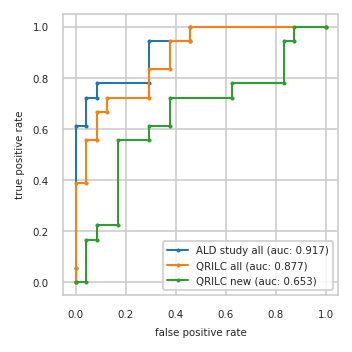

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.042 0.000
2          0.000 0.611     0.000 0.389     0.042 0.167
3          0.042 0.611     0.042 0.389     0.083 0.167
4          0.042 0.722     0.042 0.556     0.083 0.222
5          0.083 0.722     0.083 0.556     0.167 0.222
6          0.083 0.778     0.083 0.667     0.167 0.556
7          0.292 0.778     0.125 0.667     0.292 0.556
8          0.292 0.944     0.125 0.722     0.292 0.611
9          0.458 0.944     0.292 0.722     0.375 0.611
10         0.458 1.000     0.292 0.833     0.375 0.722
11         1.000 1.000     0.375 0.833     0.625 0.722
12           NaN   NaN     0.375 0.944     0.625 0.778
13           NaN   NaN     0.458 0.944     0.833 0.778
14           NaN   NaN     0.458 1.000     0.833 0.944
15           NaN   NaN     1.000 1.000     0.875 0.944
16           NaN   NaN       NaN   NaN     0.875 1.000
17           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,P31321
1,F5H265,P60709;P63261,None
2,P01258;P01258-2;P06881,P10636-2;P10636-6,None
3,P61981,A0A0A0MRJ7;P12259,None
4,P14174,P14174,None
5,P04075,P61981,None
6,P00338;P00338-3,P04075,None
7,C9JF17;P05090,P00338;P00338-3,None
8,Q9Y2T3;Q9Y2T3-3,C9JF17;P05090,None


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


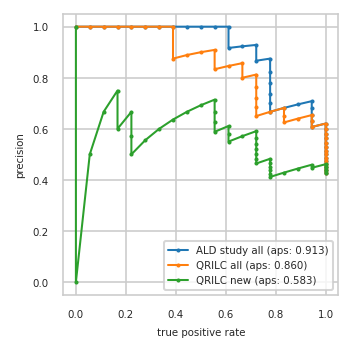

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.444 0.889
7          0.514 1.000     0.514 1.000     0.429 0.833
8          0.529 1.000     0.529 1.000     0.412 0.778
9          0.545 1.000     0.545 1.000     0.424 0.778
10         0.562 1.000     0.562 1.000     0.438 0.778
11         0.581 1.000     0.581 1.000     0.452 0.778
12         0.600 1.000     0.600 1.000     0.467 0.778
13         0.621 1.000     0.621 1.000     0.483 0.778
14         0.607 0.944     0.607 0.944     0.464 0.722
15         0.630 0.944     0.630 0.944     0.481 0.722
16         0.654 0.944     0.654 0.944     0.500 0.722
17         0.680 0.944     0.640 0.889     0.520 0.722
18         0.708 0.944     0.625 0.833     0.542 0.722
19         0.696 0.889     0.652 0.833     0.565 0.722
20         0.682 0.833     0.682 0.833     0.591 0.722
21         0.667 0.778     0.667 0.778     0.571 0.667
22         0.700 0.778     0.650 0.722     0.550 0.611
23         0.737 0.778     0.684 0.722     0.579 0.611
24         0.778 0.778     0.722 0.722     0.611 0.611
25         0.824 0.778     0.765 0.722     0.588 0.556
26         0.875 0.778     0.812 0.722     0.625 0.556
27         0.867 0.722     0.800 0.667     0.667 0.556
28         0.929 0.722     0.857 0.667     0.714 0.556
29         0.923 0.667     0.846 0.611     0.692 0.500
30         0.917 0.611     0.833 0.556     0.667 0.444
31         1.000 0.611     0.909 0.556     0.636 0.389
32         1.000 0.556     0.900 0.500     0.600 0.333
33         1.000 0.500     0.889 0.444     0.556 0.278
34         1.000 0.444     0.875 0.389     0.500 0.222
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


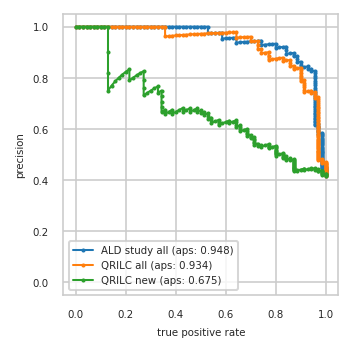

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


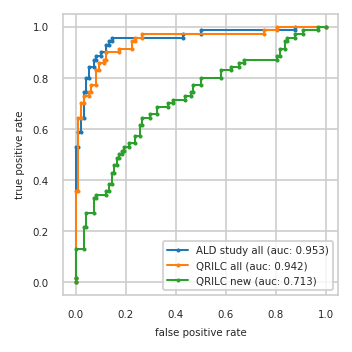

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}